In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import os

In [96]:
# Manually read and parse the file line by line to extract the structured data

def dataSize_packetLatency(file_path, y, cluster=3):
    data_list = []
    title = os.path.basename(os.path.dirname(file_path))
    
    with open(file_path, 'r') as file:
        next(file)  # Skip header
        for line in file:
            parts = line.split()
            if len(parts) == 7:
                data_list.append([int(parts[0]), int(parts[1]), int(parts[2]), float(parts[3]),
                                  int(parts[4]), float(parts[5]), float(parts[6])])
    
    # Create DataFrame and filter out rows with zero Total_Data_Size
    data_df = pd.DataFrame(data_list, columns=["LP_id", "Terminal_ID", "Total_Data_Size", 
                                               "Aggregate_Packet_Latency", "Num_Flits_Packets_Finished", 
                                               "Avg_Hops", "Busy_Time"])
    data_filtered_df = data_df[data_df["Total_Data_Size"] > 0].copy()
    
    # Clustering based on Total Data Size only
    X = data_filtered_df[["Total_Data_Size"]].values
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    data_filtered_df["Cluster"] = kmeans.fit_predict(X)
    
    # Determine the min and max Total Data Size for each cluster
    cluster_ranges = data_filtered_df.groupby("Cluster")["Total_Data_Size"].agg(["min", "max"]).reset_index()
    
    # Sort clusters by the minimum data size to ensure smallest cluster number for smallest data
    cluster_ranges = cluster_ranges.sort_values("min").reset_index(drop=True)
    cluster_ranges["New_Cluster"] = cluster_ranges.index  # Assign new cluster numbers based on order

    # Map old cluster numbers to new ones
    cluster_map = dict(zip(cluster_ranges["Cluster"], cluster_ranges["New_Cluster"]))
    interval_map = dict(zip(cluster_ranges["New_Cluster"], cluster_ranges.apply(lambda row: f"{int(row['min'])}-{int(row['max'])}", axis=1)))
    
    # Apply the new cluster labels to the data
    data_filtered_df["Cluster"] = data_filtered_df["Cluster"].map(cluster_map).astype(str)
    
    # Ensure clusters on x-axis are sorted starting from 0
    data_filtered_df["Cluster"] = pd.Categorical(data_filtered_df["Cluster"], ordered=True, categories=sorted(data_filtered_df["Cluster"].unique()))

    # Create a violin plot for aggregate packet latency grouped by new cluster numbers
    plt.figure(figsize=(8, 6))
    sns.violinplot(x="Cluster", y="Aggregate_Packet_Latency", data=data_filtered_df, order=sorted(data_filtered_df["Cluster"].unique()))
    plt.title(f"{title}")
    plt.xlabel("Cluster Number", fontsize=18)
    plt.ylabel("Aggregate Packet Latency (ns)", fontsize=18)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.ylim(0, y)
    plt.grid(axis='y')
    
    # Add a legend to indicate data size intervals for each cluster
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f"Cluster {i}: {interval_map[i]}",
                          markerfacecolor='black', markersize=8) for i in range(cluster)]
    plt.legend(handles=handles, title="Data Size Interval (Bytes)", title_fontsize='13', fontsize='11')
    
    plt.show()

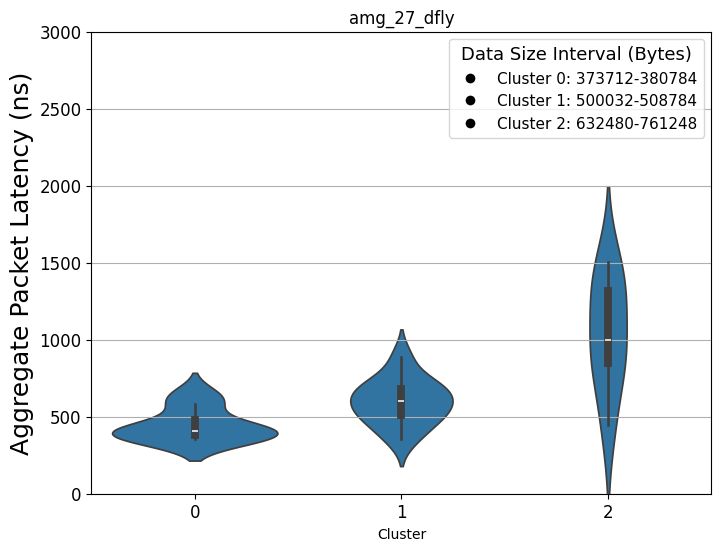

In [83]:
dataSize_packetLatency("./arxiv/amg_27_dfly/dragonfly-msg-stats",3000)

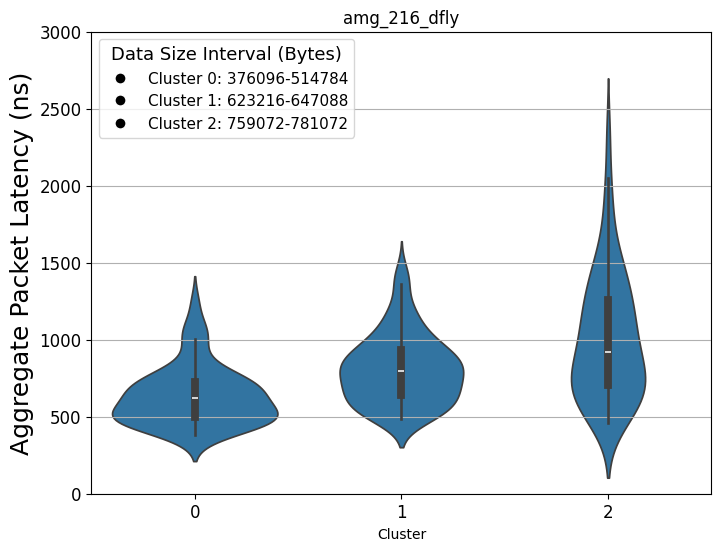

In [84]:
dataSize_packetLatency("./arxiv/amg_216_dfly/dragonfly-msg-stats",3000)

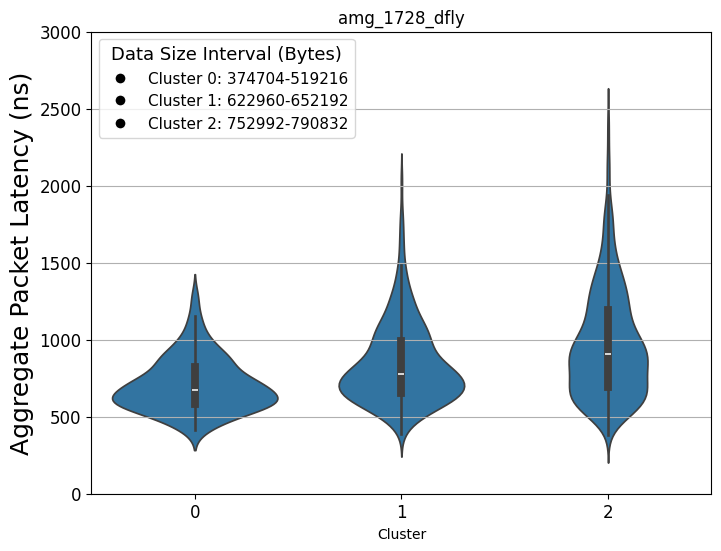

In [85]:
dataSize_packetLatency("./arxiv/amg_1728_dfly/dragonfly-msg-stats",3000)

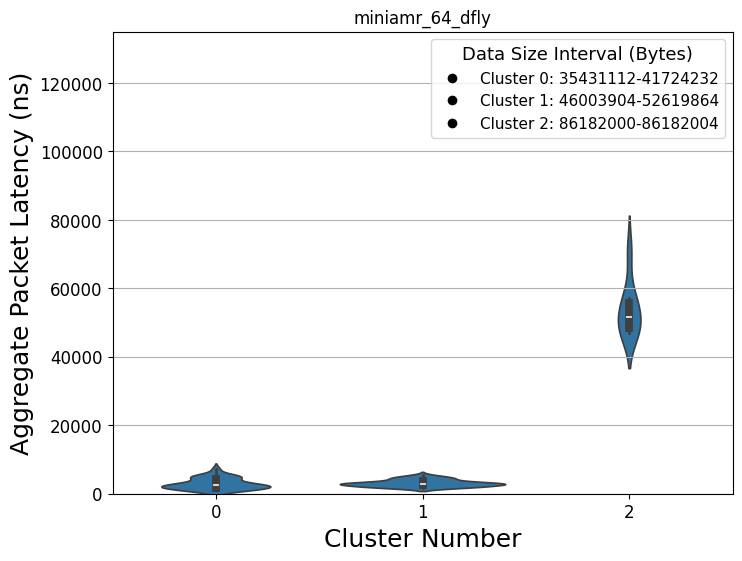

In [103]:
dataSize_packetLatency("./arxiv/miniamr_64_dfly/dragonfly-msg-stats",135000,3)

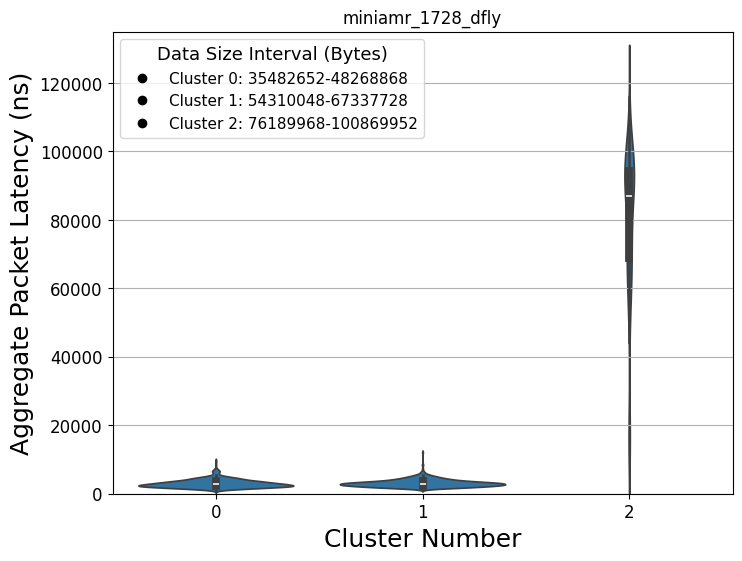

In [102]:
dataSize_packetLatency("./arxiv/miniamr_1728_dfly/dragonfly-msg-stats",135000,3)